In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:.1f}".format

### Game Analysis

In [2]:
df_game = pd.read_csv('E:\COM480-DataVis\datavis-project-2022-y3\Data\match_results.csv', 
                      parse_dates=['date'],
                      usecols=['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament'])
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament
0,1872-11-30,Scotland,England,0,0,Friendly
1,1873-03-08,England,Scotland,4,2,Friendly
2,1874-03-07,Scotland,England,2,1,Friendly
3,1875-03-06,England,Scotland,2,2,Friendly
4,1876-03-04,Scotland,England,3,0,Friendly


First thing first, we are going to filter the dataframe by year of which matches were held, as well as tournament that are methods of qualifaction toward FIFA world cup, or just world cup games. To be specific, we only keep games took place after 1990 that were part of the following tournaments:
- AFC Asian Cup
- AFC Asian Cup qualification
- African Cup of Nations
- African Cup of Nations qualification
- Copa América
- Copa América qualification
- FIFA World Cup
- FIFA World Cup qualification
- Oceania Nations Cup
- UEFA Euro
- UEFA Euro qualification
- UEFA Nations League


In [3]:
# Filter data by year and tournament

# Only keep games from 1990
df_game = df_game[df_game.date.dt.year >= 1990]

# Only keep tournament that are methods of qualifaction for world cup, that is:
tournaments=['AFC Asian Cup', 'AFC Asian Cup qualification', 'African Cup of Nations', 'African Cup of Nations qualification', 'Copa América', 'Copa América qualification'
             'FIFA World Cup', 'FIFA World Cup qualification', 'Oceania Nations Cup', 'UEFA Euro', 'UEFA Euro qualification', 'UEFA Nations League']

df_game = df_game[df_game.tournament.isin(tournaments)]
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament
16061,1990-03-02,Algeria,Nigeria,5,1,African Cup of Nations
16062,1990-03-03,Cameroon,Zambia,0,1,African Cup of Nations
16063,1990-03-03,Ivory Coast,Egypt,3,1,African Cup of Nations
16064,1990-03-03,Senegal,Kenya,0,0,African Cup of Nations
16066,1990-03-05,Algeria,Ivory Coast,3,0,African Cup of Nations


In [4]:
# One-hot Encoding on result of the match

# In football matches on a home-and-away basis, draw is equivalent to away team win
df_game['result'] = df_game.apply(lambda Row: 'home_win' if Row['home_score'] > Row['away_score'] else 'away_win', axis=1)

# One-hot Encoding
df_game = pd.get_dummies(df_game, columns=['result'])
df_game.head()

,date,home_team,away_team,home_score,away_score,tournament,result_away_win,result_home_win
16061,1990-03-02,Algeria,Nigeria,5,1,African Cup of Nations,0,1
16062,1990-03-03,Cameroon,Zambia,0,1,African Cup of Nations,1,0
16063,1990-03-03,Ivory Coast,Egypt,3,1,African Cup of Nations,0,1
16064,1990-03-03,Senegal,Kenya,0,0,African Cup of Nations,1,0
16066,1990-03-05,Algeria,Ivory Coast,3,0,African Cup of Nations,0,1


In [5]:
# Calculate goal difference

df_game["goal_diff"] = df_game.home_score - df_game.away_score
df_game["home_goal_diff"] = df_game.apply(lambda Row: Row['goal_diff'] if Row['goal_diff'] > 0 else 0, axis=1)
df_game["away_goal_diff"] = df_game.apply(lambda Row: -Row['goal_diff'] if Row['goal_diff'] <= 0 else 0, axis=1)
df_game.drop(['goal_diff'], axis=1, inplace=True)

In [6]:
df_game

,date,home_team,away_team,home_score,away_score,tournament,result_away_win,result_home_win,home_goal_diff,away_goal_diff
16061,1990-03-02,Algeria,Nigeria,5,1,African Cup of Nations,0,1,4,0
16062,1990-03-03,Cameroon,Zambia,0,1,African Cup of Nations,1,0,0,1
16063,1990-03-03,Ivory Coast,Egypt,3,1,African Cup of Nations,0,1,2,0
16064,1990-03-03,Senegal,Kenya,0,0,African Cup of Nations,1,0,0,0
16066,1990-03-05,Algeria,Ivory Coast,3,0,African Cup of Nations,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...
43178,2022-01-30,Senegal,Equatorial Guinea,3,1,African Cup of Nations,0,1,2,0
43184,2022-02-02,Burkina Faso,Senegal,1,3,African Cup of Nations,1,0,0,2
43185,2022-02-03,Cameroon,Egypt,0,0,African Cup of Nations,1,0,0,0
43186,2022-02-05,Cameroon,Burkina Faso,3,3,African Cup of Nations,1,0,0,0


In [7]:
# Gather statistics: number of win and lose matches as home team and away team respectively, as well as total

df_home_count = df_game.groupby('home_team').agg({'result_home_win': 'sum', 'away_team': 'count', 'home_score': 'sum', 'home_goal_diff': 'sum'})\
                                            .rename(columns={'result_home_win':'home_win', 'away_team': 'home_count'}).reset_index()

df_away_count = df_game.groupby('away_team').agg({'result_away_win': 'sum', 'home_team': 'count', 'away_score': 'sum', 'away_goal_diff': 'sum'})\
                                            .rename(columns={'result_away_win':'away_win', 'home_team': 'away_count'}).reset_index()

df_game_stat = df_home_count.merge(df_away_count, left_on='home_team', right_on='away_team', how='inner').drop(['away_team'], axis=1)
df_game_stat.rename(columns={'home_team':'team'}, inplace=True)

df_game_stat['total_count'] = df_game_stat.home_count + df_game_stat.away_count
df_game_stat['total_win']   = df_game_stat.home_win + df_game_stat.away_win
df_game_stat['total_score'] = df_game_stat.home_score + df_game_stat.away_score

df_game_stat['home_lose']  = df_game_stat.home_count - df_game_stat.home_win
df_game_stat['away_lose']  = df_game_stat.away_count - df_game_stat.away_win
df_game_stat['total_lose'] = df_game_stat.home_lose + df_game_stat.away_lose

# Win rate statistics
df_game_stat['home_win_rate']   = df_game_stat.home_win / df_game_stat.home_count
df_game_stat['away_win_rate']   = df_game_stat.away_win / df_game_stat.away_count
df_game_stat['total_win_rate']  = df_game_stat.total_win / df_game_stat.total_count

# Goal difference statistics
df_game_stat['avg_home_goal_diff']  = df_game_stat.home_goal_diff / df_game_stat.home_win
df_game_stat['avg_away_goal_diff']  = df_game_stat.away_goal_diff / df_game_stat.away_win
df_game_stat['total_goal_diff']     = df_game_stat.home_goal_diff + df_game_stat.away_goal_diff
df_game_stat['avg_total_goal_diff'] = df_game_stat.total_goal_diff / df_game_stat.total_win

# Fill 0 for teams with 0 home_win and/or away_win count 
df_game_stat = df_game_stat.fillna(0)
df_game_stat.head()

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,...,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Afghanistan,4,14,15,6,6,16,9,2,30,...,10,10,20,0.3,0.4,0.3,1.5,0.3,8,0.8
1,Albania,28,84,90,45,31,86,62,32,170,...,56,55,111,0.3,0.4,0.3,1.6,1.0,77,1.3
2,Algeria,59,89,193,146,57,98,104,46,187,...,30,41,71,0.7,0.6,0.6,2.5,0.8,192,1.7
3,American Samoa,0,4,1,0,0,4,0,0,8,...,4,4,8,0.0,0.0,0.0,0.0,0.0,0,0.0
4,Andorra,4,67,22,5,5,67,17,3,134,...,63,62,125,0.1,0.1,0.1,1.2,0.6,8,0.9


In [8]:
# Show top 20 teams ordered by total matches, total number of winned matches, and the average goal difference
df_game_stat.sort_values(by=['total_count', 'total_win', 'avg_total_goal_diff'], ascending=False).head(20)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,...,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
94,Italy,72,101,208,158,87,99,143,95,200,...,29,12,41,0.7,0.9,0.8,2.2,1.1,253,1.6
177,Spain,80,98,290,257,86,100,193,128,198,...,18,14,32,0.8,0.9,0.8,3.2,1.5,385,2.3
151,Portugal,71,100,240,192,81,98,178,118,198,...,29,17,46,0.7,0.8,0.8,2.7,1.5,310,2.0
95,Ivory Coast,68,99,228,169,75,98,122,72,197,...,31,23,54,0.7,0.8,0.7,2.5,1.0,241,1.7
34,Cameroon,76,115,196,145,63,82,111,65,197,...,39,19,58,0.7,0.8,0.7,1.9,1.0,210,1.5
203,Uruguay,54,101,168,109,50,96,91,37,197,...,47,46,93,0.5,0.5,0.5,2.0,0.7,146,1.4
54,Denmark,56,95,183,138,77,97,163,109,192,...,39,20,59,0.6,0.8,0.7,2.5,1.4,247,1.9
8,Argentina,72,112,216,154,58,79,108,60,191,...,40,21,61,0.6,0.7,0.7,2.1,1.0,214,1.6
42,Colombia,53,97,140,104,62,94,93,47,191,...,44,32,76,0.5,0.7,0.6,2.0,0.8,151,1.3
59,Egypt,79,103,247,196,60,87,96,53,190,...,24,27,51,0.8,0.7,0.7,2.5,0.9,249,1.8


In [9]:
df_game_stat.describe()

,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,total_win,...,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
count,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,...,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0,213.0
mean,26.7,53.8,90.6,63.8,27.1,53.8,58.3,31.5,107.6,53.8,...,27.1,26.7,53.8,0.4,0.4,0.4,2.2,1.1,95.3,1.7
std,22.1,31.7,71.8,58.7,23.2,30.3,47.5,32.8,61.5,44.6,...,16.3,15.7,31.0,0.2,0.2,0.2,0.9,0.9,89.1,0.7
min,0.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,8.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,6.0,23.0,28.0,15.0,7.0,25.0,18.0,7.0,45.0,14.0,...,13.0,14.0,30.0,0.3,0.3,0.3,1.8,0.7,22.0,1.3
50%,21.0,56.0,75.0,47.0,20.0,58.0,43.0,19.0,115.0,43.0,...,26.0,26.0,52.0,0.5,0.4,0.4,2.1,1.0,67.0,1.6
75%,43.0,83.0,140.0,97.0,45.0,82.0,93.0,47.0,164.0,87.0,...,36.0,36.0,69.0,0.6,0.6,0.6,2.7,1.4,148.0,2.0
max,80.0,115.0,334.0,298.0,87.0,101.0,202.0,151.0,200.0,166.0,...,81.0,79.0,160.0,0.8,1.0,0.9,5.1,8.0,385.0,4.3


The table above shows the match statistics in the past ~30 years, 

In [10]:
# Show top 20 teams with highest avg_total_goal_diff
df_game_stat.sort_values(by=['total_goal_diff'], ascending=False).head(20).reset_index(drop=True)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,...,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Spain,80,98,290,257,86,100,193,128,198,...,18,14,32,0.8,0.9,0.8,3.2,1.5,385,2.3
1,Australia,72,88,334,298,47,61,107,81,149,...,16,14,30,0.8,0.8,0.8,4.1,1.7,379,3.2
2,Netherlands,75,99,266,225,66,88,177,127,187,...,24,22,46,0.8,0.8,0.8,3.0,1.9,352,2.5
3,Iran,64,95,237,199,79,93,202,151,188,...,31,14,45,0.7,0.8,0.8,3.1,1.9,350,2.4
4,Germany,62,89,245,184,76,91,200,146,180,...,27,15,42,0.7,0.8,0.8,3.0,1.9,330,2.4
5,England,65,93,221,178,75,87,179,138,180,...,28,12,40,0.7,0.9,0.8,2.7,1.8,316,2.3
6,Japan,59,84,228,184,68,80,166,127,164,...,25,12,37,0.7,0.8,0.8,3.1,1.9,311,2.4
7,Portugal,71,100,240,192,81,98,178,118,198,...,29,17,46,0.7,0.8,0.8,2.7,1.5,310,2.0
8,Saudi Arabia,72,94,258,218,53,70,108,72,164,...,22,17,39,0.8,0.8,0.8,3.0,1.4,290,2.3
9,Belgium,56,86,215,168,60,85,148,103,171,...,30,25,55,0.7,0.7,0.7,3.0,1.7,271,2.3


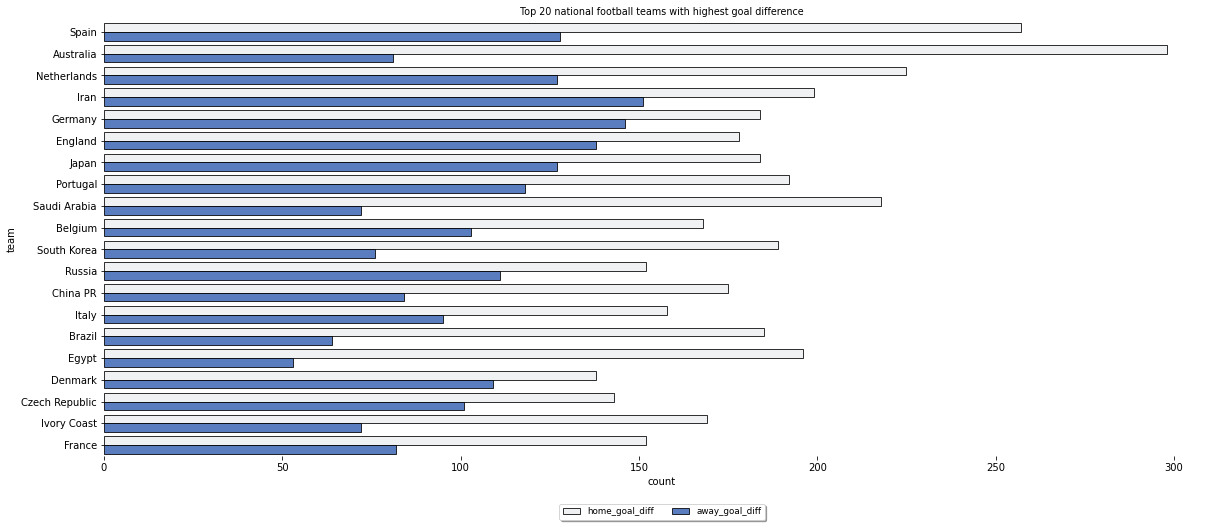

In [11]:
# Visualisation

# Process df for visualisation
df_vis = df_game_stat.sort_values(by=['total_goal_diff'], ascending=False).head(20)
df_vis = df_vis[['team', 'home_goal_diff', 'away_goal_diff']]
df_vis = df_vis.set_index('team').stack().reset_index()
df_vis.rename({'level_1': 'place', 0: 'count'}, axis=1, inplace=True)

f, ax = plt.subplots(figsize = (20,8))

sns.set_context('paper')

sns.set_color_codes('muted')
sns.barplot(x = 'count', y = 'team', hue = 'place',
           data = df_vis, color = 'b', edgecolor = 'black')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
sns.despine(left = True, bottom = True)
plt.title("Top 20 national football teams with highest goal difference")
plt.show()


In [12]:
# Show top 20 teams with most wins
df_game_stat.sort_values(by=['total_win'], ascending=False).head(20).reset_index(drop=True)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,...,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Spain,80,98,290,257,86,100,193,128,198,...,18,14,32,0.8,0.9,0.8,3.2,1.5,385,2.3
1,Italy,72,101,208,158,87,99,143,95,200,...,29,12,41,0.7,0.9,0.8,2.2,1.1,253,1.6
2,Portugal,71,100,240,192,81,98,178,118,198,...,29,17,46,0.7,0.8,0.8,2.7,1.5,310,2.0
3,Nigeria,78,103,206,162,66,84,97,58,187,...,25,18,43,0.8,0.8,0.8,2.1,0.9,220,1.5
4,Iran,64,95,237,199,79,93,202,151,188,...,31,14,45,0.7,0.8,0.8,3.1,1.9,350,2.4
5,Ivory Coast,68,99,228,169,75,98,122,72,197,...,31,23,54,0.7,0.8,0.7,2.5,1.0,241,1.7
6,Netherlands,75,99,266,225,66,88,177,127,187,...,24,22,46,0.8,0.8,0.8,3.0,1.9,352,2.5
7,England,65,93,221,178,75,87,179,138,180,...,28,12,40,0.7,0.9,0.8,2.7,1.8,316,2.3
8,Cameroon,76,115,196,145,63,82,111,65,197,...,39,19,58,0.7,0.8,0.7,1.9,1.0,210,1.5
9,Egypt,79,103,247,196,60,87,96,53,190,...,24,27,51,0.8,0.7,0.7,2.5,0.9,249,1.8


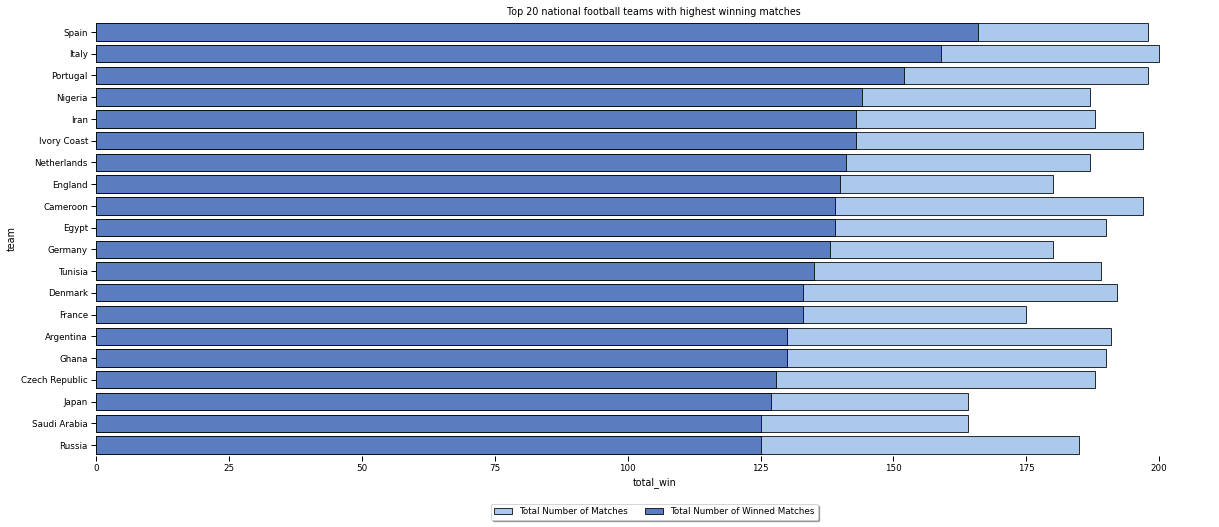

In [13]:
# Visualisation

df_vis = df_game_stat.sort_values(by=['total_win'], ascending=False).head(20)

sns.set_context('paper')

f, ax = plt.subplots(figsize = (20,8))

sns.set_color_codes('pastel')
sns.barplot(x = 'total_count', y = 'team', data = df_vis,
            label = 'Total Number of Matches', color = 'b', edgecolor = 'black')

sns.set_color_codes('muted')
sns.barplot(x = 'total_win', y = 'team', data = df_vis,
            label = 'Total Number of Winned Matches', color = 'b', edgecolor = 'black')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
sns.despine(left = True, bottom = True)
plt.title("Top 20 national football teams with highest winning matches")
plt.show()

In [14]:
# Show top 10 teams with highest win rate
df_game_stat.sort_values(by=['total_win_rate'], ascending=False).head(20).reset_index(drop=True)

,team,home_win,home_count,home_score,home_goal_diff,away_win,away_count,away_score,away_goal_diff,total_count,...,home_lose,away_lose,total_lose,home_win_rate,away_win_rate,total_win_rate,avg_home_goal_diff,avg_away_goal_diff,total_goal_diff,avg_total_goal_diff
0,Yugoslavia,3,4,16,13,4,4,8,8,8,...,1,0,1,0.8,1.0,0.9,4.3,2.0,21,3.0
1,Spain,80,98,290,257,86,100,193,128,198,...,18,14,32,0.8,0.9,0.8,3.2,1.5,385,2.3
2,Australia,72,88,334,298,47,61,107,81,149,...,16,14,30,0.8,0.8,0.8,4.1,1.7,379,3.2
3,Italy,72,101,208,158,87,99,143,95,200,...,29,12,41,0.7,0.9,0.8,2.2,1.1,253,1.6
4,England,65,93,221,178,75,87,179,138,180,...,28,12,40,0.7,0.9,0.8,2.7,1.8,316,2.3
5,Japan,59,84,228,184,68,80,166,127,164,...,25,12,37,0.7,0.8,0.8,3.1,1.9,311,2.4
6,Nigeria,78,103,206,162,66,84,97,58,187,...,25,18,43,0.8,0.8,0.8,2.1,0.9,220,1.5
7,Portugal,71,100,240,192,81,98,178,118,198,...,29,17,46,0.7,0.8,0.8,2.7,1.5,310,2.0
8,Germany,62,89,245,184,76,91,200,146,180,...,27,15,42,0.7,0.8,0.8,3.0,1.9,330,2.4
9,Saudi Arabia,72,94,258,218,53,70,108,72,164,...,22,17,39,0.8,0.8,0.8,3.0,1.4,290,2.3


### Player Analysis


In [15]:
df_player = pd.read_csv('E:\COM480-DataVis\datavis-project-2022-y3\Data\players_21_value.csv')
df_player.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,103500000.0,560000.0,33,...,52+3,52+3,52+3,62+3,19+3,https://cdn.sofifa.net/players/158/023/21_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",92,92,63000000.0,220000.0,35,...,54+3,54+3,54+3,61+3,20+3,https://cdn.sofifa.net/players/020/801/21_120.png,https://cdn.sofifa.net/teams/45/60.png,https://cdn.sofifa.net/flags/it.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
2,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,91,91,111000000.0,240000.0,31,...,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/21_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,NaN,https://cdn.sofifa.net/flags/pl.png
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,132000000.0,270000.0,28,...,49+3,49+3,49+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/21_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CAM, CM",91,91,129000000.0,370000.0,29,...,69+3,69+3,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/21_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png


In [21]:
list(df_player.columns)

['sofifa_id',
 'player_url',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agi